<a href="https://colab.research.google.com/github/Im-LAKSH/OCT_Image_Classification/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Using Device: cuda

📂 Loading Dataset...
   • Training on 4383 images
   • Testing on 133 images
   • Classes: ['CSR', 'DR', 'MH', 'NORMAL']

🧠 Downloading ResNet18...

🚀 STARTING TRAINING...

Epoch 1/15
----------
TRAIN Loss: 0.5928 Acc: 0.8337
TEST Loss: 0.8158 Acc: 0.6617

Epoch 2/15
----------
TRAIN Loss: 0.2354 Acc: 0.9468
TEST Loss: 0.7565 Acc: 0.6992

Epoch 3/15
----------
TRAIN Loss: 0.1794 Acc: 0.9530
TEST Loss: 0.6241 Acc: 0.7293

Epoch 4/15
----------
TRAIN Loss: 0.1533 Acc: 0.9567
TEST Loss: 0.5613 Acc: 0.7594

Epoch 5/15
----------
TRAIN Loss: 0.1419 Acc: 0.9594
TEST Loss: 0.5432 Acc: 0.7594

Epoch 6/15
----------
TRAIN Loss: 0.1321 Acc: 0.9644
TEST Loss: 0.5330 Acc: 0.7820

Epoch 7/15
----------
TRAIN Loss: 0.1169 Acc: 0.9630
TEST Loss: 0.5249 Acc: 0.7820

Epoch 8/15
----------
TRAIN Loss: 0.1177 Acc: 0.9630
TEST Loss: 0.4825 Acc: 0.7895

Epoch 9/15
----------
TRAIN Loss: 0.1044 Acc: 0.9681
TEST Loss: 0.5111 Acc: 0.7820

Epoch 10/15
----------
TRAIN Loss: 0.1042 Acc: 0.

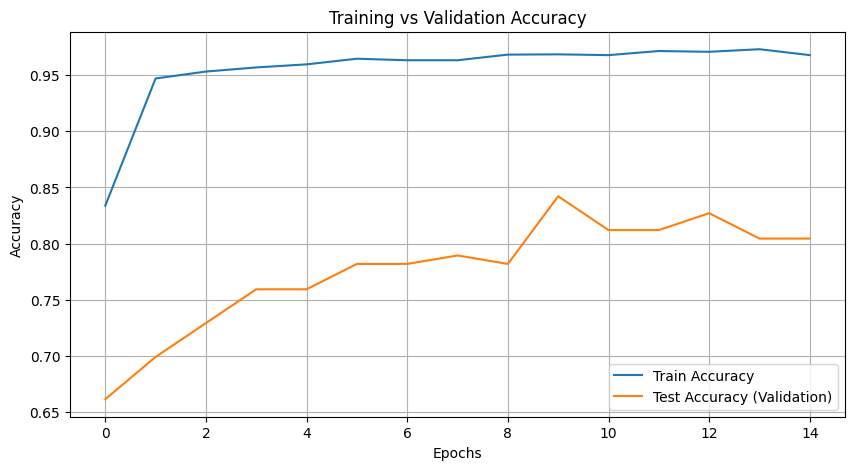

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time
import os
import copy
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

if not os.path.exists('/content/drive'):
    print("🔌 Mounting Google Drive...")
    drive.mount('/content/drive')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using Device: {device}")


data_dir = '/content/drive/MyDrive/Final_Dataset_For_CNN'
num_classes = 4
batch_size = 32
num_epochs = 15

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("\n📂 Loading Dataset...")
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
               for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

print(f"   • Training on {dataset_sizes['train']} images")
print(f"   • Testing on {dataset_sizes['test']} images")
print(f"   • Classes: {class_names}")


print("\n🧠 Downloading ResNet18...")
model = models.resnet18(pretrained=True)


for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)


criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []

    print("\n🚀 STARTING TRAINING...")
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0


            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.upper()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train': train_acc_history.append(epoch_acc.item())
            if phase == 'test': val_acc_history.append(epoch_acc.item())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'🏆 Best Test Accuracy: {best_acc:.4f}')


    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history


final_model, train_hist, test_hist = train_model(model, criterion, optimizer, num_epochs=num_epochs)


save_path = '/content/drive/MyDrive/OCT_ResNet_Model.pth'
torch.save(final_model.state_dict(), save_path)
print(f"\n💾 Model saved to: {save_path}")


plt.figure(figsize=(10,5))
plt.title("Training vs Validation Accuracy")
plt.plot(train_hist, label="Train Accuracy")
plt.plot(test_hist, label="Test Accuracy (Validation)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

🔍 Inspecting Image: NORMAL150.jpg
🏷️ True Label: NORMAL
🧠 Loading your trained model...


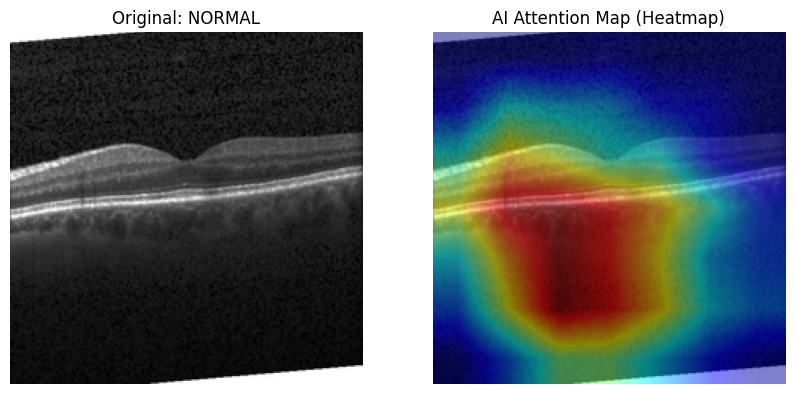

In [ ]:

!pip install grad-cam

import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import os
import random
import glob

model_path = '/content/drive/MyDrive/OCT_ResNet_Model.pth'
test_dir = '/content/drive/MyDrive/Final_Dataset_For_CNN/test'


all_test_images = glob.glob(os.path.join(test_dir, '*', '*.jpg')) + glob.glob(os.path.join(test_dir, '*', '*.png'))
image_path = random.choice(all_test_images)
true_label = os.path.basename(os.path.dirname(image_path))

print(f"🔍 Inspecting Image: {os.path.basename(image_path)}")
print(f"🏷️ True Label: {true_label}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("🧠 Loading your trained model...")
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()


def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)
    return img, input_tensor


target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

rgb_img, input_tensor = preprocess_image(image_path)
grayscale_cam = cam(input_tensor=input_tensor)
grayscale_cam = grayscale_cam[0, :]


rgb_img_resized = np.float32(rgb_img.resize((224, 224))) / 255
visualization = show_cam_on_image(rgb_img_resized, grayscale_cam, use_rgb=True)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(rgb_img_resized)
ax[0].set_title(f"Original: {true_label}")
ax[0].axis('off')

ax[1].imshow(visualization)
ax[1].set_title("AI Attention Map (Heatmap)")
ax[1].axis('off')

plt.show()

✅ Device: cuda
🚀 Training on 4383 | Testing on 133

🧠 Downloading ResNet18 and Unfreezing Layer 4...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🔥 STARTING FINE-TUNING RUN...

Epoch 1/25
----------
TRAIN Loss: 0.1291 Acc: 0.9555
TEST Loss: 0.1768 Acc: 0.9474

Epoch 2/25
----------
TRAIN Loss: 0.0257 Acc: 0.9925
TEST Loss: 0.0842 Acc: 0.9699

Epoch 3/25
----------
TRAIN Loss: 0.0210 Acc: 0.9913
TEST Loss: 0.1343 Acc: 0.9549

Epoch 4/25
----------
TRAIN Loss: 0.0120 Acc: 0.9963
TEST Loss: 0.2597 Acc: 0.9173

Epoch 5/25
----------
TRAIN Loss: 0.0129 Acc: 0.9954
TEST Loss: 0.1080 Acc: 0.9549

Epoch 6/25
----------
TRAIN Loss: 0.0080 Acc: 0.9979
TEST Loss: 0.0991 Acc: 0.9774

Epoch 7/25
----------
TRAIN Loss: 0.0166 Acc: 0.9938
TEST Loss: 0.0897 Acc: 0.9774

Epoch 8/25
----------
TRAIN Loss: 0.0046 Acc: 0.9995
TEST Loss: 0.0853 Acc: 0.9774

Epoch 9/25
----------
TRAIN Loss: 0.0068 Acc: 0.9970
TEST Loss: 0.0705 Acc: 0.9850

Epoch 10/25
----------
TRAIN Loss: 0.0065 Acc: 0.9982
TEST Loss: 0.0714 Acc: 0.9850

Epoch 11/25
----------
TRAIN Loss: 0.0032 Acc: 0.9989
TEST Loss: 0.0766 Acc: 0.9850

Epoch 12/25
----------
TRAIN Loss: 0.0053 

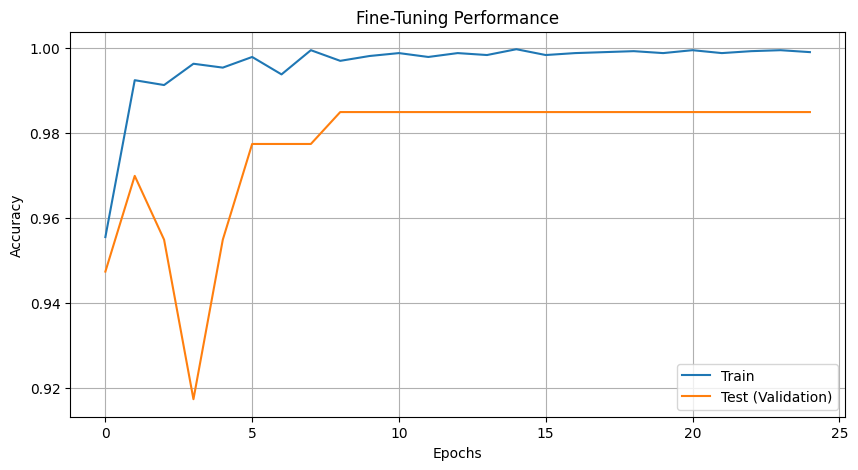

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time
import os
import copy
import matplotlib.pyplot as plt
from google.colab import drive


if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device: {device}")

data_dir = '/content/drive/MyDrive/Final_Dataset_For_CNN'
num_classes = 4
batch_size = 32
num_epochs = 25


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
               for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

print(f"🚀 Training on {dataset_sizes['train']} | Testing on {dataset_sizes['test']}")


print("\n🧠 Downloading ResNet18 and Unfreezing Layer 4...")
model = models.resnet18(pretrained=True)

for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam([
    {'params': list(model.layer4.parameters()), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])


exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_hist, val_hist = [], []

    print("\n🔥 STARTING FINE-TUNING RUN...")
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train': model.train()
            else: model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train': scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.upper()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train': train_hist.append(epoch_acc.item())
            if phase == 'test': val_hist.append(epoch_acc.item())

    time_elapsed = time.time() - since
    print(f'\n🎉 Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'🏆 BEST TEST ACCURACY: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_hist, val_hist

final_model, train_hist, test_hist = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)


save_path = '/content/drive/MyDrive/OCT_ResNet_95_Plus.pth'
torch.save(final_model.state_dict(), save_path)
print(f"\n💾 High-Accuracy Model saved to: {save_path}")

plt.figure(figsize=(10,5))
plt.plot(train_hist, label="Train")
plt.plot(test_hist, label="Test (Validation)")
plt.title("Fine-Tuning Performance")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

🔍 Inspecting: NORMAL205.jpg
🏷️ True Label: NORMAL
🧠 Loading the Super Model...


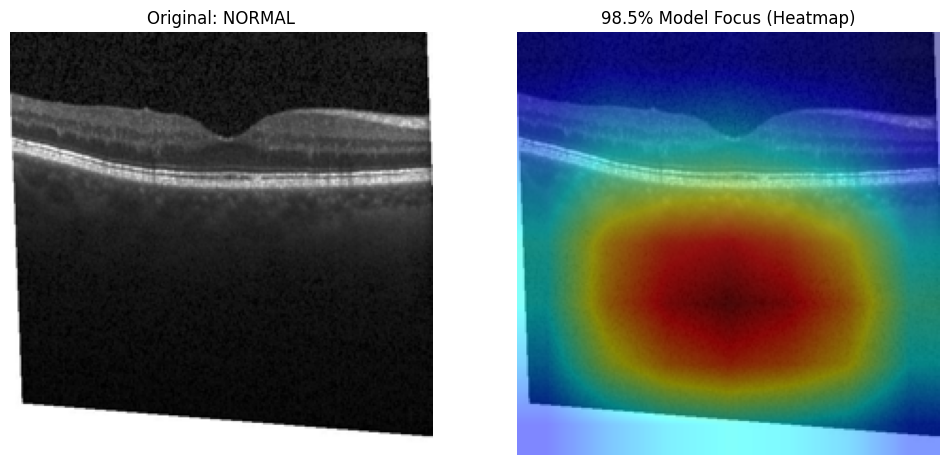

In [ ]:

import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import os
import random
import glob


model_path = '/content/drive/MyDrive/OCT_ResNet_95_Plus.pth'
test_dir = '/content/drive/MyDrive/Final_Dataset_For_CNN/test'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


all_test_images = glob.glob(os.path.join(test_dir, '*', '*.jpg')) + glob.glob(os.path.join(test_dir, '*', '*.png'))
image_path = random.choice(all_test_images)
true_label = os.path.basename(os.path.dirname(image_path))

print(f"🔍 Inspecting: {os.path.basename(image_path)}")
print(f"🏷️ True Label: {true_label}")


print("🧠 Loading the Super Model...")
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()


def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)
    return img, input_tensor


target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

rgb_img, input_tensor = preprocess_image(image_path)
grayscale_cam = cam(input_tensor=input_tensor)
grayscale_cam = grayscale_cam[0, :]


rgb_img_resized = np.float32(rgb_img.resize((224, 224))) / 255
visualization = show_cam_on_image(rgb_img_resized, grayscale_cam, use_rgb=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(rgb_img_resized)
ax[0].set_title(f"Original: {true_label}")
ax[0].axis('off')

ax[1].imshow(visualization)
ax[1].set_title(f"98.5% Model Focus (Heatmap)")
ax[1].axis('off')

plt.show()

🧠 Loading Model: OCT_ResNet_95_Plus.pth...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


🔍 Scanning Test Set...


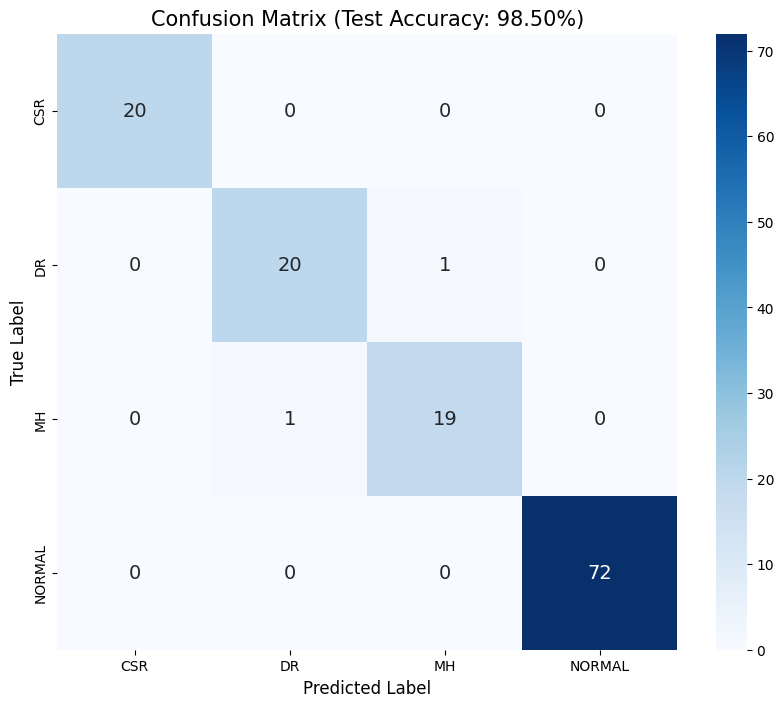


📊 DETAILED CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

         CSR       1.00      1.00      1.00        20
          DR       0.95      0.95      0.95        21
          MH       0.95      0.95      0.95        20
      NORMAL       1.00      1.00      1.00        72

    accuracy                           0.98       133
   macro avg       0.98      0.98      0.98       133
weighted avg       0.98      0.98      0.98       133

------------------------------------------------------------


In [ ]:

import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = '/content/drive/MyDrive/Final_Dataset_For_CNN'

model_path = '/content/drive/MyDrive/OCT_ResNet_95_Plus.pth'

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = test_dataset.classes


print(f"🧠 Loading Model: {os.path.basename(model_path)}...")
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()


all_preds = []
all_labels = []

print("🔍 Scanning Test Set...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


cm = confusion_matrix(all_labels, all_preds)
accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 14})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix (Test Accuracy: {accuracy:.2f}%)', fontsize=15)
plt.show()


print("\n📊 DETAILED CLASSIFICATION REPORT")
print("-" * 60)
print(classification_report(all_labels, all_preds, target_names=class_names))
print("-" * 60)

🧠 Loading 98.5% Model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


🔍 analyzing test set (Calculating Probabilities)...


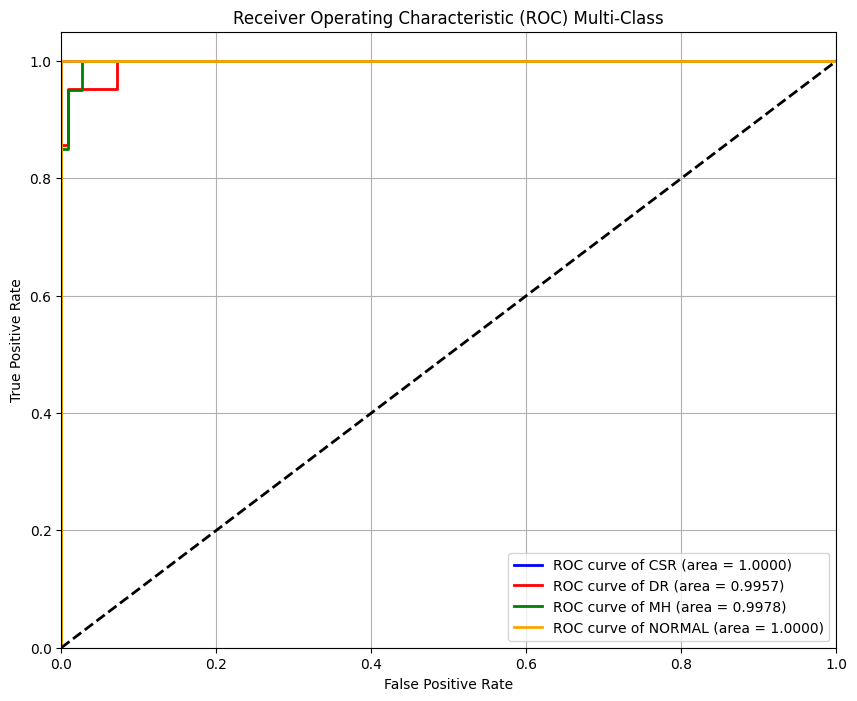


📊 DETAILED MEDICAL METRICS (Copy for Paper)
    Class  Sensitivity (Recall)  Specificity  Accuracy
0     CSR                1.0000       1.0000     1.000
1      DR                0.9524       0.9911     0.985
2      MH                0.9500       0.9912     0.985
3  NORMAL                1.0000       1.0000     1.000

❌ FOUND 2 ERRORS. DISPLAYING THEM NOW...


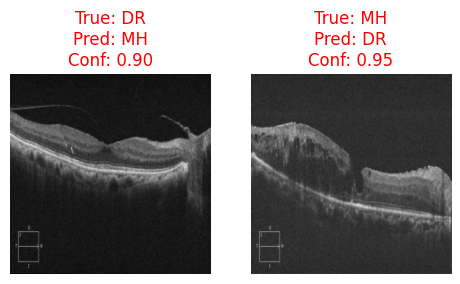

In [ ]:

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = '/content/drive/MyDrive/Final_Dataset_For_CNN'
model_path = '/content/drive/MyDrive/OCT_ResNet_95_Plus.pth'


data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = test_dataset.classes
n_classes = len(class_names)

print("🧠 Loading 98.5% Model...")
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, n_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

y_test = []
y_score = []
wrong_predictions = []

print("🔍 analyzing test set (Calculating Probabilities)...")
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        y_test.extend(labels.cpu().numpy())
        y_score.extend(probs.cpu().numpy())


        for j in range(inputs.size(0)):
            if preds[j] != labels[j]:
                wrong_predictions.append({
                    'image': inputs[j].cpu(),
                    'true': class_names[labels[j]],
                    'pred': class_names[preds[j]],
                    'conf': probs[j][preds[j]].item()
                })

y_test = np.array(y_test)
y_score = np.array(y_score)


y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.4f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Multi-Class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

cm = confusion_matrix(y_test, np.argmax(y_score, axis=1))


def calculate_metrics(cm):
    metrics = []
    for i in range(len(cm)):
        tp = cm[i, i]
        fn = sum(cm[i, :]) - tp
        fp = sum(cm[:, i]) - tp
        tn = sum(sum(cm)) - tp - fn - fp

        sensitivity = tp / (tp + fn) if (tp+fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn+fp) > 0 else 0
        accuracy = (tp + tn) / sum(sum(cm))

        metrics.append([class_names[i], sensitivity, specificity, accuracy])
    return metrics

metrics_data = calculate_metrics(cm)
df_metrics = pd.DataFrame(metrics_data, columns=['Class', 'Sensitivity (Recall)', 'Specificity', 'Accuracy'])

print("\n📊 DETAILED MEDICAL METRICS (Copy for Paper)")
print(df_metrics.round(4))


if len(wrong_predictions) > 0:
    print(f"\n❌ FOUND {len(wrong_predictions)} ERRORS. DISPLAYING THEM NOW...")
    fig = plt.figure(figsize=(15, 5))
    for idx, err in enumerate(wrong_predictions[:5]):
        ax = fig.add_subplot(1, 5, idx+1)
        img = err['image'].permute(1, 2, 0).numpy()

        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"True: {err['true']}\nPred: {err['pred']}\nConf: {err['conf']:.2f}", color='red')
        ax.axis('off')
    plt.show()
else:
    print("\n✅ AMAZING! No errors found in the test set to display.")